### This notebook has been solely created for the purpose of doing the Spark assignments on a local machine.

Hence, the outputs might differ from the final submission notebook created, since only a small fraction of the dataset has been used to practice the questions on my local machine

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

spark = SparkSession \
    .builder \
    .appName("databricks-exercise") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
sqlContext = SQLContext(spark)
from pyspark.sql import functions as f

In [2]:
csvFile=spark.read.csv('export.csv',header=True,inferSchema=True)

In [3]:
csvFile.select('UniqueCarrier').distinct().count()

14

The most delayed on departure airline is AA.


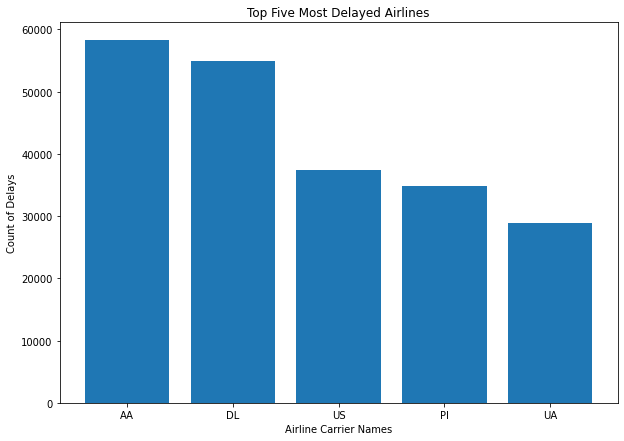

In [4]:
df = csvFile
import matplotlib.pyplot as plt

#get a view dataframe sorted desc order
view=df.groupby("UniqueCarrier").agg(f.sum((f.when(f.col('IsDepDelayed')=='YES',1)))\
                                     .alias('Count')).sort(f.col('Count').desc())

# display(view.head()) returns an array of the topmost value 
print("The most delayed on departure airline is {}.".format(view.head()[0]))

#getting a bar graph of top five delayed airlines converting the Dataframe to a Pandas Dataframe to use matplotlib
bar1=view.toPandas()
name = bar1['UniqueCarrier'].head(5)
price = bar1['Count'].head(5)
 
# Figure Size according to my preference
fig = plt.figure(figsize =(10, 7))
 
# Horizontal Bar Plot
plt.bar(name, price)
plt.title('Top Five Most Delayed Airlines')
plt.xlabel('Airline Carrier Names')
plt.ylabel('Count of Delays')
# Show Plot
plt.show()


#### Airlines Question 4 [15 Points]
What was the average arrival delay per airline, and on average, did flights arrive early or late? 

Add a column to this new dataframe (containing the grouped averages) that contains the string "Late" if the average arrival for that airline arrive >15 minutes late, "Early" if the average arrival is <0 minutes late, and "On-time" if the average arrival is between 0 and 15 minutes late.

To add the additional column, use a Spark UDF. Additionally, make sure to filter out or fill in null values in your dataframe (if there are any) prior to applying the UDF.

In [5]:
#remove NA values
dataframe=df.where(df.ArrDelay!='NA')

# sub ques 1
#Show Mean Arrival Delays Grouping by Unique Carrier
print("Average Arrival Delay Per Airline")
dataframe.groupBy("UniqueCarrier").agg(f.mean('ArrDelay')\
                                       .alias('Average Arrival Delay Time (in minutes)'))\
.sort(f.col('Average Arrival Delay Time (in minutes)')).show()

#create a new dataframe based on asc sorted dataframe
new_df=dataframe.groupBy("UniqueCarrier").agg(f.mean('ArrDelay')\
                                              .alias('Average Arrival Delay Time (in minutes)'))\
.sort(f.col('Average Arrival Delay Time (in minutes)'))

print("\n")


#Show aggregted average Arrival Delay Time 

agg_avg=new_df.agg(f.mean('Average Arrival Delay Time (in minutes)')\
           .alias('Average Arrival Delay for all Airlines (in minutes)')).head()

if agg_avg[0]<0:
    print("Flights on average arrived Early.")
elif agg_avg[0]>15:
    print("Flights on average arrived Late.")
else:
    print("Flights arrived On Time.")

new_df.agg(f.mean('Average Arrival Delay Time (in minutes)')\
           .alias('Average Arrival Delay for all Airlines (in minutes)')).show()

print("\n\n")

#sub ques 2
#Creating a new Dataframe and using Spark UDF withColum() function
print("Dataframe with status column")
new_df.withColumn("Status", f.when(f.column('Average Arrival Delay Time (in minutes)')
                                       .between(0,15),"On Time")\
                  .when(f.column('Average Arrival Delay Time (in minutes)')<0.0,"Early")\
                  .otherwise("Late")
                 ).show()


Average Arrival Delay Per Airline


+-------------+---------------------------------------+
|UniqueCarrier|Average Arrival Delay Time (in minutes)|
+-------------+---------------------------------------+
|           AA|                      6.207145998858287|
|       PA (1)|                      7.462260986246226|
|           WN|                      9.602103642893791|
|           HP|                      9.975197889182057|
|           US|                     10.417063299336247|
|           AS|                     10.884908628827302|
|           PI|                      11.34330879004099|
|           EA|                     11.709370804618276|
|           TW|                     12.986250332653242|
|           DL|                     13.875554158671342|
|           CO|                     14.538406041075465|
|           NW|                     14.999943054013269|
|           UA|                     15.911314285714285|
|           PS|                     21.705255951928198|
+-------------+---------------------------------

+---------------------------------------------------+
|Average Arrival Delay for all Airlines (in minutes)|
+---------------------------------------------------+
|                                 12.258434561718499|
+---------------------------------------------------+




Dataframe with status column
+-------------+---------------------------------------+-------+
|UniqueCarrier|Average Arrival Delay Time (in minutes)| Status|
+-------------+---------------------------------------+-------+
|           AA|                      6.207145998858287|On Time|
|       PA (1)|                      7.462260986246226|On Time|
|           WN|                      9.602103642893791|On Time|
|           HP|                      9.975197889182057|On Time|
|           US|                     10.417063299336247|On Time|
|           AS|                     10.884908628827302|On Time|
|           PI|                      11.34330879004099|On Time|
|           EA|                     11.709370804618276|On

## Using Baby Names Data Set

This dataset comes from a website referenced by [Data.gov](http://catalog.data.gov/dataset/baby-names-beginning-2007). It lists baby names used in the state of NY from 2007 to 2012.

Run the following three cells to copy this file to the cluster.

https://health.data.ny.gov/api/views/jxy9-yhdk/rows.json?accessType=DOWNLOAD

%fs rm dbfs:/tmp/rows.json

%scala

import java.net.URL
import java.io.File
import org.apache.commons.io.FileUtils

val tmpFile = new File("/tmp/rows.json")
FileUtils.copyURLToFile(new URL("https://health.data.ny.gov/api/views/jxy9-yhdk/rows.json?accessType=DOWNLOAD"), tmpFile)

%fs mv file:/tmp/rows.json dbfs:/tmp/rows.json

#### Baby Names Question 1 - Nested Data [15 Points]


Use Spark SQL's native JSON support to read the baby names file into a dataframe. Use this dataframe to create a temporary table containing all the nested data columns ("sid", "id", "position", "created_at", "created_meta", "updated_at", "updated_meta", "meta", "year", "first_name", "county", "sex", "count") so that they can be queried using SQL. 

Hint: you can use ```%fs head dbfs:/tmp/rows.json``` to take a look at the dataset before reading it in. 

Suggested Steps:
1. Read in the JSON data
2. Pull all columns in the nested data column to top level, following the schema specified above
3. Create a temp table from this expanded dataframe using createOrReplaceTempView()

In [6]:
from pyspark.sql.functions import explode

spark.read.json('rows.json', multiLine=True).select(explode("data").alias("data")).createOrReplaceTempView("data")
insightData=sqlContext.sql("SELECT data[0] AS sid, data[1] AS id, data[2] AS position, data[3] AS created_at, data[4] AS created_meta, data[5] AS updated_at, data[6] AS updated_meta, data[7] AS meta, data[8] AS year, data[9] AS first_name, data[10] AS country, data[11] AS sex, data[12] AS count FROM data")


insightData.show()
insightData.createOrReplaceTempView("insightData")


22/04/01 02:49:22 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+--------------------+--------+----------+------------+----------+------------+----+----+----------+-----------+---+-----+
|               sid|                  id|position|created_at|created_meta|updated_at|updated_meta|meta|year|first_name|    country|sex|count|
+------------------+--------------------+--------+----------+------------+----------+------------+----+----+----------+-----------+---+-----+
|row-r9pv-p86t.ifsp|00000000-0000-000...|       0|1574264158|        null|1574264158|        null| { }|2007|      ZOEY|      KINGS|  F|   11|
|row-7v2v~88z5-44se|00000000-0000-000...|       0|1574264158|        null|1574264158|        null| { }|2007|      ZOEY|    SUFFOLK|  F|    6|
|row-hzc9-4kvv~mbc9|00000000-0000-000...|       0|1574264158|        null|1574264158|        null| { }|2007|      ZOEY|     MONROE|  F|    6|
|row-3473_8cwy~3vez|00000000-0000-000...|       0|1574264158|        null|1574264158|        null| { }|2007|      ZOEY|       ERIE|  F|    9|
|row-t

Show most popular baby names for a year

In [66]:
# table=sqlContext.sql("SELECT year,max(count) as counter,first_name from insightData GROUP BY first_name,year order by max(count) desc")
table=sqlContext.sql('''SELECT
 name,
 count,
 year
FROM (
  SELECT
     first_name as name,
 count,
 year,
    dense_rank() OVER (PARTITION BY year ORDER BY count DESC) as rank
  FROM insightData ) x 
WHERE
  x.rank == 1
order by year''')
table.createOrReplaceTempView("table")
table.show(n=32,truncate=False)

+--------+-----+----+
|name    |count|year|
+--------+-----+----+
|JOHN    |99   |2007|
|JAKE    |99   |2007|
|JEREMIAH|99   |2008|
|MATTHEW |99   |2008|
|JACK    |99   |2009|
|SOPHIA  |99   |2009|
|MADISON |99   |2009|
|CHAIM   |99   |2010|
|JUSTIN  |99   |2010|
|LOGAN   |99   |2010|
|GABRIEL |99   |2011|
|JAYDEN  |99   |2011|
|AARON   |99   |2011|
|JOSHUA  |99   |2011|
|MENACHEM|99   |2011|
|MIA     |99   |2011|
|MADISON |99   |2012|
|JASON   |99   |2012|
|JAMES   |99   |2013|
|AARON   |99   |2013|
|DYLAN   |99   |2013|
|JAMES   |99   |2014|
|JOSHUA  |99   |2014|
|LOGAN   |99   |2015|
|SOPHIA  |99   |2015|
|ANTHONY |99   |2016|
|MATTHEW |99   |2016|
|MATTHEW |99   |2016|
|DYLAN   |99   |2017|
|ABIGAIL |99   |2018|
|LUCAS   |99   |2018|
|OLIVIA  |99   |2018|
+--------+-----+----+




[Stage 242:>                                                        (0 + 1) / 1]



  #### Baby Names Question 4 - Nested XML [15 Points]
Imagine that a new upstream system now automatically adds an XML field to the JSON baby dataset.  The added field is called visitors. It contains an XML string with visitor information for a given birth. We have simulated this upstream system by creating another JSON file with the additional field.  

Using the JSON dataset at https://raw.githubusercontent.com/jservin/scratch-pad/master/rows-with-xml.json, do the following:
1. read the rows-with-xml.json file into a dataframe and parse the nested XML fields into columns
2. Find the county with the highest average number of visitors across all births in that county
3. Find the average visitor age for a birth in the county of KINGS
4. Find the most common birth visitor age in the county of KINGS


In [7]:
df = spark.read.option("inferSchema", True).json("births-with-visitor-data.json")

#learnt how to make a custom udf 
#stackoverflow reference https://stackoverflow.com/a/65644185
import xml.etree.ElementTree as ET
import pyspark.sql.functions as F

@F.udf('array<struct<id:string, age:string, sex:string>>')
def parse_xml(s):
    root = ET.fromstring(s)
    return list(map(lambda x: x.attrib, root.findall('visitor')))


#create a nested struct dataframe after parsing
df2 = df.select(df["county"], df["created_at"], df["first_name"], F.col("id").alias("Birth ID"), df["meta"], df["name_count"], 
                df["position"], df["sex"], df["sid"], df["updated_at"],df["year"],F.explode(parse_xml('visitors')).alias('visitors'))



#final dataframe (answer for subques1)
#display struct items individally and reassign the dataframe
df2=df2.select(df2["sid"],df2["Birth ID"],df2["position"],\
               df2["created_at"],df2["updated_at"],df2["meta"],\
               df2["year"],df2["first_name"],df2["county"],df2["sex"],df2["name_count"],\
               df2["visitors.id"].alias("id of visitor"),df2["visitors.age"].alias("age of visitor"),df2["visitors.sex"].alias("sex of visitor"))
df2.show(truncate=False)

+------------------+------------------------------------+--------+----------+----------+----+----+----------+-----------+---+----------+-------------+--------------+--------------+
|sid               |Birth ID                            |position|created_at|updated_at|meta|year|first_name|county     |sex|name_count|id of visitor|age of visitor|sex of visitor|
+------------------+------------------------------------+--------+----------+----------+----+----+----------+-----------+---+----------+-------------+--------------+--------------+
|row-r9pv-p86t.ifsp|00000000-0000-0000-0838-60C2FFCC43AE|0       |1574264158|1574264158|{ } |2007|ZOEY      |KINGS      |F  |11        |9615         |68            |F             |
|row-r9pv-p86t.ifsp|00000000-0000-0000-0838-60C2FFCC43AE|0       |1574264158|1574264158|{ } |2007|ZOEY      |KINGS      |F  |11        |1882         |34            |M             |
|row-r9pv-p86t.ifsp|00000000-0000-0000-0838-60C2FFCC43AE|0       |1574264158|1574264158|{ } |20

2. Find the county with the highest average number of visitors across all births in that county

In [68]:
#subques2
df3=df2.groupBy(df2["Birth ID"],df2["county"]).agg(f.count(df2["Birth ID"]).alias("Number of Visitors"))
df3=df3.groupBy(df3["county"]).agg(f.mean(df3["Number of Visitors"]).alias("Average Number of Visitors")).sort(f.col('Average Number of Visitors').desc())
df3.show()
print("County with highest average number of visitors across all births is {}".format(df3.head()[0]))

+----------+--------------------------+
|    county|Average Number of Visitors|
+----------+--------------------------+
|    SENECA|                       2.9|
|    Otsego|        2.8823529411764706|
|   Orleans|                      2.75|
|  Chenango|         2.727272727272727|
|    Putnam|        2.7261904761904763|
|   Wyoming|        2.7142857142857144|
|    WARREN|        2.6736842105263157|
|    Warren|         2.652173913043478|
|Rensselaer|         2.640909090909091|
|   Clinton|        2.6363636363636362|
|   ORLEANS|        2.6315789473684212|
|  CHENANGO|                     2.625|
|   GENESEE|         2.617283950617284|
| SCHOHARIE|        2.6153846153846154|
|    Oneida|        2.6136363636363638|
|   WYOMING|         2.611111111111111|
|  SULLIVAN|        2.6083333333333334|
|   Madison|        2.6052631578947367|
|Chautauqua|        2.6036585365853657|
|    Ulster|         2.599009900990099|
+----------+--------------------------+
only showing top 20 rows




[Stage 251:>                                                        (0 + 8) / 8]



County with highest average number of visitors across all births is SENECA


In [69]:
#creating a dataframe where values have not been exploded from struct format
df=df.select(df["sid"], F.col("id").alias("Birth ID"),df["position"],\
             df["created_at"],df["updated_at"],df["meta"],\
             df["year"],df["first_name"],df["county"],df["sex"],df["name_count"],\
             F.explode(parse_xml('visitors')).alias('visitors'))#modify dataframe for subques(3-4)

#modifying data for subques(3-4)
df=df.where(df["county"]=="KINGS")

#sub-ques3
df.agg(f.mean(df["visitors.age"]).alias("Average Age of Vistors in KINGS")).show(truncate=False)
val=df.agg(f.mean(df["visitors.age"]).alias("Average Age of Vistors in KINGS")).head()
print("Average Age of visitors in KINGS is {} years.".format(val[0]))

+-------------------------------+
|Average Age of Vistors in KINGS|
+-------------------------------+
|34.72654917566799              |
+-------------------------------+

Average Age of visitors in KINGS is 34.72654917566799 years.


In [70]:
#subques4
age_count = df.groupby('visitors.age').count()
age_count.sort(f.col('count').desc()).show()

#head returns topmost array
val=age_count.sort(f.col('count').desc()).head()
print("The most common birth visitor age is {} with a frequency of {} in the county KINGS.".format(val[0],val[1]))

+---+-----+
|age|count|
+---+-----+
| 58|  210|
| 39|  206|
| 49|  204|
| 64|  203|
| 36|  202|
| 65|  202|
| 61|  202|
| 48|  197|
| 47|  193|
| 32|  193|
| 20|  191|
|  6|  191|
| 51|  189|
|  2|  189|
| 25|  188|
|  9|  188|
| 18|  187|
| 68|  186|
| 57|  184|
| 28|  183|
+---+-----+
only showing top 20 rows

The most common birth visitor age is 58 with a frequency of 210 in the county KINGS.
